In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [46]:
# Definizione delle funzioni
def retta(x, a, b):
    return a + b*x

def fit_Tf_R(x, Q, ft, B):
    return B/np.sqrt(1+Q**2*((ft/x)**2-(x/ft)**2)**2)

def fit_phi_R(x, Q, ft):
    return np.arctan(Q*(ft/x-x/ft))


def fit_Tf_C(x, Q, ft, A):
    return A/np.sqrt((1-(x/ft)**2)**2+(x/(ft*Q))**2)

def fit_phi_C(x, Q, ft, a):
    return np.arctan(Q**-1/(ft/x-x/ft))


In [3]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [22]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati R.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

sVin = np.sqrt((0.03*data["Ach1"]/(24**0.5))**2+(data["Sch1"]/(25*24**0.5))) # Assumo triangolare

Tf = data["Ach2"]/data["Ach1"]
sTf = np.sqrt((0.03*data["Ach2"]/(12**0.5))**2+(data["Sch2"]/(25*12**0.5)) + (data["Ach2"]/data["Ach1"] * sVin)**2)/data["Ach1"] # Assumo uniforme

frequenze = []
sfrequenze = []

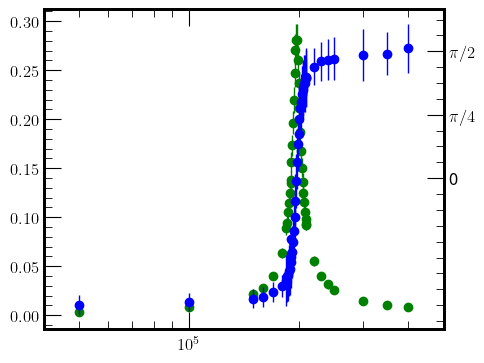

In [23]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='bo')

axA.set_xlim(min(f)-1e4,max(f)+10**5)

plt.show()

[1.15639689e+01 1.97316314e+05 2.80296440e-01] [[ 1.82287812e-01  1.42502632e-01  2.70525769e-03]
 [ 1.42502632e-01  1.56838171e+04 -8.79724483e-03]
 [ 2.70525769e-03 -8.79724483e-03  5.00350145e-05]]
0.07063947956350546


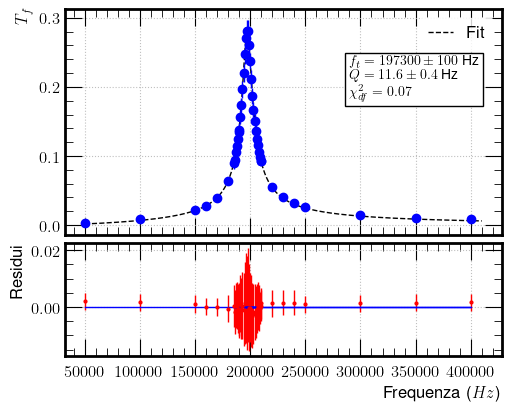

In [24]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_R, f, Tf, p0=[36, 196850, 0.3], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr)

resTr = Tf - fit_Tf_R(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_R(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2Tf/(len(f)-1))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

[-1.95766988e+01  1.96807854e+05] [[ 4.34806578e+00 -7.63719114e+01]
 [-7.63719114e+01  2.06860905e+05]]
7.551183373049978e-05


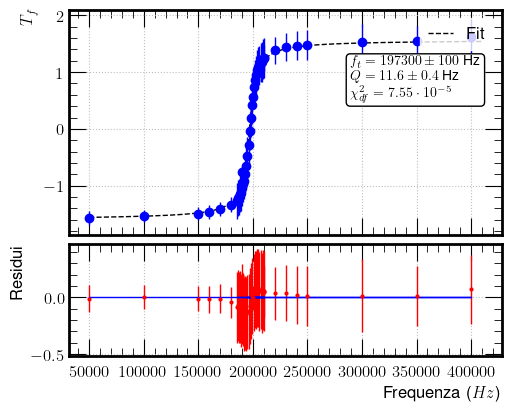

In [25]:
# Fit della funzione di trasferimento non lineare
valphi, covphi = curve_fit(fit_phi_R, f, phi, p0=[36, 196850], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi)

resphi = phi - fit_phi_R(f, *valphi)
chi2phi = np.sum((resTr/sphi)**2)
print(chi2phi/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_R(x_fit, *valphi), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, phi, yerr=sphi , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phi/(len(f)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resphi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

In [40]:
# Importazione dei dati per fit globale
dataC = pd.read_csv('Dati C.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fC = dataC["f"]
phi = 2e-9 * np.pi * dataC["f"] * dataC["dT"] # in rapporto a 90°
sphi = 2e-9 * np.pi * dataC["f"] * np.sqrt(dataC["sT"]/(10*12**0.5))

for i in range(len(phi)):
    print(phi[i], dataC["dT"][i])

sVin = np.sqrt((0.03*dataC["Ach1"]/(24**0.5))**2+(dataC["Sch1"]/(25*24**0.5))) # Assumo triangolare

TfC = dataC["Ach2"]/dataC["Ach1"]
sTfC = np.sqrt((0.03*dataC["Ach2"]/(12**0.5))**2+(dataC["Sch2"]/(25*12**0.5)) + (dataC["Ach2"]/dataC["Ach1"] * sVin)**2)/dataC["Ach1"] # Assumo uniforme

0.025132741228718343 40
0.07539822368615504 80
0.11058406140636073 110
0.16022122533307945 150
0.23750440461138836 210
0.6088406562657019 510
2.324778563656447 1850
2.836858166191583 2150
2.958123642620149 2140
3.0058758509547143 2080
3.0159289474462017 2000
3.0316369107141505 1930
3.0724776152108175 1630
3.078760800517997 1400
3.0913271711323564 1230
1.3477432483900214 1100
1.5886405730672866 1290
1.8195476331061364 1470
2.0278352260391395 1630
2.2131263607478657 1770
2.450065278681608 1940
2.5384068641005526 2000
2.6019926994092106 2040
2.666081189542442 2080
2.704911274740812 2100
2.743992687351469 2120
2.770319233788552 2130
2.7967714439317772 2140
2.8233493177811475 2150
2.836858166191583 2150
1.1336122931213408 930
0.9519339899642433 785
0.808268957915582 670
0.6900508263609981 575
0.6088406562657019 510
0.5225096901450544 440
0.4724955350999049 400
0.4229840348793298 360
0.373975189483329 320
0.34871678454846705 300


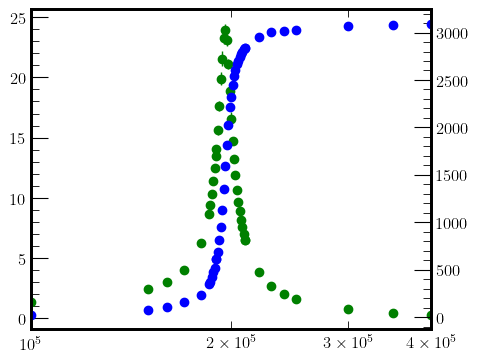

In [28]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(fC, TfC, yerr=sTfC , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.errorbar(fC, phi,  yerr= sphi, xerr=sphi , fmt='bo')

axA.set_xlim(min(fC),max(fC))

plt.show()

[2.35801335e+01 1.95961150e+05 1.01010516e+00] [[ 8.04253805e-02  3.10934944e-01 -8.93167963e-04]
 [ 3.10934944e-01  1.82428194e+03 -3.00714915e-02]
 [-8.93167963e-04 -3.00714915e-02  2.21475903e-05]]
0.11386972278221485


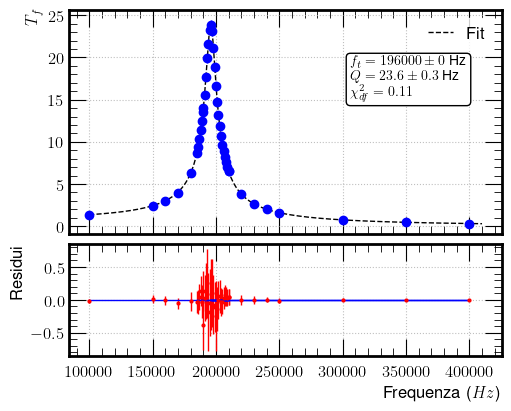

In [29]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_C, fC, TfC, p0=[11.6, 197300, 1], method='lm' ,sigma=sTfC, absolute_sigma=True)
print(valtr, covtr)

resTr = TfC - fit_Tf_C(fC, *valtr)
chi2TfC = np.sum((resTr/sTfC)**2)
print(chi2TfC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_C(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, TfC, yerr=sTfC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2TfC/(len(fC)-1))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)

ax[1].errorbar(fC,resTr,yerr=sTfC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

[3.37257176e+07 1.95999989e+05 1.85246750e+00] [[ 4.45514634e+18  1.08484031e+09 -4.19974717e+03]
 [ 1.08484031e+09  2.64161581e-01 -1.02258708e-06]
 [-4.19974717e+03 -1.02258708e-06  1.93887311e-09]]
18949466.73540884


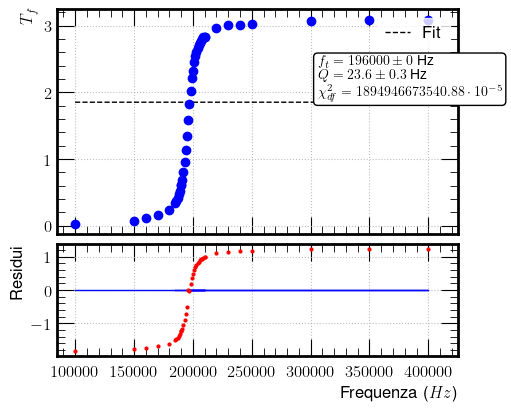

In [47]:
# Fit della funzione di trasferimento non lineare
valphi, covphi = curve_fit(fit_phi_C, fC, phi, p0=[11, 196850, np.pi/2], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi)

resphi = phi - fit_phi_C(fC, *valphi)
chi2phi = np.sum((resphi/sphi)**2)
print(chi2phi/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_C(x_fit, *valphi), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, phi, yerr=sphi , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phi/(len(fC)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(fC,resphi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

# Da fixare questo fit